## Introduction

In this notebook it is shown how we get our results. The main idea of our method is to do transfer-learning. We did download the weights corresponding to the VG16 model and then we first retrained the last layer to our first classes. Next we did finetune the last convolutional layers, taking care not do get overfitting by using a small learning rate.  

this are the packages we used:

In [45]:
import numpy as np
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from keras.models import Sequential, Model
from keras.layers import Dropout, Flatten, Dense, Input
from keras import applications
from keras import optimizers

from keras import backend as K
K.set_image_dim_ordering('th')
import os
from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
import progressbar
from IPython.display import Image, display, clear_output
import matplotlib.pyplot as plt

The path to the datafolder and the parameters. The data folder is divided in 3 subfolders test, train and validation, containing 20%, 60% and 20% of the data respectively. Each of  this folder is oneach turn split in two subfolders again, one malignant and wan benign.

In [20]:
#test that your are where you are
PATH="/home/ubuntu/data/"
folders=os.listdir(PATH)
print(folders)
os.chdir(PATH)

['validation', 'train', 'test']


In [21]:
# dimensions of our images.
img_width, img_height = 150, 150
top_model_weights_path = 'bottleneck_fc_model.h5'
train_data_dir = PATH+'train/'
validation_data_dir =PATH+ 'validation/'
test_dir =PATH+ 'test/'
nb_train_samples = 832
nb_validation_samples = 368
epochs = 50
batch_size = 16

# Data augmentation

We used the following data augmentation

In [22]:
datagen = ImageDataGenerator(
        rescale=1. / 255,
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

Then we saved the bottleneck features, that is we took the VGG16 network. We took pathches of our data, aumentated it and loaded it through VG16 except the last layer. We did save the outcome of the network in in the bottle neck features. So we got bottleneck features for the train and validation data. 

In [23]:
def save_bottlebeck_features():
    #datagen = ImageDataGenerator(rescale=1. / 255)

    # build the VGG16 network
    model = applications.VGG16(include_top=False, weights='imagenet')

    generator = datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode=None,
        shuffle=False)
    bottleneck_features_train = model.predict_generator(
        generator, nb_train_samples // batch_size)
    np.save('bottleneck_features_train',
        bottleneck_features_train)

    print("done train")
    generator = datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode=None,
        shuffle=False)
    bottleneck_features_validation = model.predict_generator(
        generator, nb_validation_samples // batch_size)
    np.save('bottleneck_features_validation',
            bottleneck_features_validation)
    print("done valid")

We used this bottleneck features as input of our top model. And we trained this top model.

In [24]:
def train_top_model():
    train_data = np.load('bottleneck_features_train.npy')
    train_labels = np.array([0] * (nb_train_samples // 2) + [1] * (nb_train_samples // 2+nb_train_samples%2))

    validation_data = np.load('bottleneck_features_validation.npy')
    validation_labels = np.array([0] * (nb_validation_samples // 2) + [1] * (nb_validation_samples // 2+nb_validation_samples%2))

    model = Sequential()
    model.add(Flatten(input_shape=train_data.shape[1:]))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer='rmsprop',
                  loss='binary_crossentropy', metrics=['accuracy'])
    print("starting fitting")
    model.fit(train_data, train_labels,
              epochs=epochs,
              batch_size=batch_size,
              validation_data=(validation_data, validation_labels))
    model.save_weights(top_model_weights_path)
    print("ended fitting and saving")


We call our functions

In [25]:
save_bottlebeck_features()

/usr/local/lib/python3.5/dist-packages/keras/applications/vgg16.py:182: UserWarning: You are using the TensorFlow backend, yet you are using the Theano image data format convention (`image_data_format="channels_first"`). For best performance, set `image_data_format="channels_last"` in your Keras config at ~/.keras/keras.json.
  warnings.warn('You are using the TensorFlow backend, yet you '


Found 841 images belonging to 2 classes.
done train
Found 373 images belonging to 2 classes.
done valid


In [26]:
train_top_model()

starting fitting
Train on 832 samples, validate on 368 samples
Epoch 1/50
832/832 [==============================] - 0s - loss: 1.0369 - acc: 0.5012 - val_loss: 0.6810 - val_acc: 0.5380
Epoch 2/50
832/832 [==============================] - 0s - loss: 0.7093 - acc: 0.5421 - val_loss: 0.7777 - val_acc: 0.5136
Epoch 3/50
832/832 [==============================] - 0s - loss: 0.7044 - acc: 0.5553 - val_loss: 0.7077 - val_acc: 0.5299
Epoch 4/50
832/832 [==============================] - 0s - loss: 0.6972 - acc: 0.5312 - val_loss: 0.7254 - val_acc: 0.5054
Epoch 5/50
832/832 [==============================] - 0s - loss: 0.6897 - acc: 0.5577 - val_loss: 0.7016 - val_acc: 0.5000
Epoch 6/50
832/832 [==============================] - 0s - loss: 0.6703 - acc: 0.5901 - val_loss: 0.6985 - val_acc: 0.5027
Epoch 7/50
832/832 [==============================] - 0s - loss: 0.6700 - acc: 0.5601 - val_loss: 0.6700 - val_acc: 0.5734
Epoch 8/50
832/832 [==============================] - 0s - loss: 0.6584 - ac

To check that we are doing it correctly we have a function that can predict what we see.

In [38]:
def predict_image_class(file):
    model = applications.VGG16(include_top=False, weights='imagenet')
    x = load_img(file, target_size=(img_width,img_height))
    x = img_to_array(x)
    x = np.expand_dims(x, axis=0)
    array = model.predict(x)
    model = Sequential()
    model.add(Flatten(input_shape=array.shape[1:]))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
    model.load_weights(top_model_weights_path)
    class_predicted = model.predict_classes(array)
    if class_predicted==1:
        print("malignant")
    else:
        print("benign")

# Fine tuning

Nex we fine tune the last convolutional layers of VGG16

In [27]:
# path to the model weights files.
weights_path = '../vgg16_weights_tf_dim_ordering_tf_kernels.h5'
top_model_weights_path = 'bottleneck_fc_model.h5'
# dimensions of our images.
img_width, img_height = 150, 150

train_data_dir = 'train'
validation_data_dir = 'validation'
test_dir = 'test'
nb_train_samples = 800
nb_validation_samples = 370
epochs = 20
batch_size = 5

input_tensor = Input(shape=(3,img_width,img_height))
base_model = applications.VGG16(weights='imagenet',include_top= False,input_tensor=input_tensor)
top_model = Sequential()
top_model.add(Flatten(input_shape=base_model.output_shape[1:]))
top_model.add(Dense(256, activation='relu'))
top_model.add(Dropout(0.5))
top_model.add(Dense(1, activation='sigmoid'))
top_model.load_weights(top_model_weights_path)
model = Model(inputs= base_model.input, outputs= top_model(base_model.output))

# set the first 25 layers (up to the last conv block)
# to non-trainable (weights will not be updated)
for layer in model.layers[:15]:
    layer.trainable = False

# compile the model with a SGD/momentum optimizer
# and a very slow learning rate.
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.SGD(lr=1e-4, momentum=0.9),
              metrics=['accuracy'])

# prepare data augmentation configuration
train_datagen = ImageDataGenerator(
        rescale=1. / 255,
        rotation_range=180,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary')

/usr/local/lib/python3.5/dist-packages/keras/applications/vgg16.py:182: UserWarning: You are using the TensorFlow backend, yet you are using the Theano image data format convention (`image_data_format="channels_first"`). For best performance, set `image_data_format="channels_last"` in your Keras config at ~/.keras/keras.json.
  warnings.warn('You are using the TensorFlow backend, yet you '


Found 841 images belonging to 2 classes.
Found 373 images belonging to 2 classes.


In [28]:
# fine-tune the model
model.fit_generator(
    train_generator,
    samples_per_epoch=nb_train_samples,
    epochs=epochs,
    validation_data=validation_generator,
    nb_val_samples=nb_validation_samples)

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:7: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  import sys
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:7: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras.pre..., validation_data=<keras.pre..., steps_per_epoch=160, epochs=20, validation_steps=370)`
  import sys


Epoch 1/20
160/160 [==============================] - 37s - loss: 0.5536 - acc: 0.7863 - val_loss: 0.6570 - val_acc: 0.6303
Epoch 2/20
160/160 [==============================] - 36s - loss: 0.4723 - acc: 0.8187 - val_loss: 0.9106 - val_acc: 0.6234
Epoch 3/20
160/160 [==============================] - 35s - loss: 0.4584 - acc: 0.8350 - val_loss: 0.6646 - val_acc: 0.6315
Epoch 4/20
160/160 [==============================] - 35s - loss: 0.4713 - acc: 0.8287 - val_loss: 0.7873 - val_acc: 0.6272
Epoch 5/20
160/160 [==============================] - 36s - loss: 0.4598 - acc: 0.8225 - val_loss: 0.6958 - val_acc: 0.6326
Epoch 6/20
160/160 [==============================] - 35s - loss: 0.4631 - acc: 0.8400 - val_loss: 0.7763 - val_acc: 0.6228
Epoch 7/20
160/160 [==============================] - 35s - loss: 0.4525 - acc: 0.8212 - val_loss: 0.6661 - val_acc: 0.6402
Epoch 8/20
160/160 [==============================] - 35s - loss: 0.4429 - acc: 0.8337 - val_loss: 0.7745 - val_acc: 0.6293
Epoch 9/

# Anylizing the results

Accuracy is not such a good measure. Because of the nature of benign and malignant it is very important not to have too many false positives, i.e., too often diagnose malignant while it is benign. Therefore, we made the confucion matrix and the receiver operating characteristic and found an area under curve of 0.7.

In [40]:
def predict_image_class(model, path_file, img_width,img_height):
    """returns class in binary classification.
    """
    x = load_img(path_file, target_size=(img_width,img_height))
    x = img_to_array(x)
    x = np.expand_dims(x, axis=0)
    value_prediction = model.predict(x)[0][0]
    return value_prediction

In [41]:
category_array = ["Malignant", "Benign"]
for trainValTest in [test_dir]:
    """
    array:
    0 actual class malignant
    1 actual class benign
    """
    confusion_matrix = [[0,0],[0,0]] 
    pred_array = [[],[]]
    for a, category in enumerate(category_array):
        cur_path = trainValTest + "/" + category + "/"
        for file in progressbar.log_progress(os.listdir(cur_path)[:]):
            if file.endswith(".jpg"):
                path_file = cur_path + file
                value_prediction = predict_image_class(model, path_file, img_width, img_height)
                pred_array[a] += [value_prediction]
                if value_prediction > 0.5:
                    confusion_matrix[a][0] += 1
                else:
                    confusion_matrix[a][1] += 1

VBox(children=(HTML(value=''), IntProgress(value=0, max=70)))

VBox(children=(HTML(value=''), IntProgress(value=0, max=234)))

In [42]:
print(confusion_matrix[0])
print(confusion_matrix[1])

[7, 63]
[3, 231]


In [43]:
TP = confusion_matrix[0][0]
FP = confusion_matrix[0][1]
FN = confusion_matrix[1][0]
TN = confusion_matrix[1][1]

AC = (TP+TN) / (TP+FP+TN+FN)#accuracy
SE = TP / (TP+FN)#sensitivity
SP = TN / (TN+FP)#specitifity
DI = (2*TP) / (2*TP + FN + FP)#dice coefficient

print(AC,SE,SP,DI)

0.7828947368421053 0.7 0.7857142857142857 0.175


And the roc curve

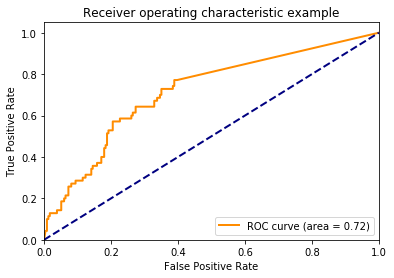

In [46]:
y_true_0 = np.ones(len(pred_array[0]))
y_true_1 = np.zeros(len(pred_array[1]))
y_true = np.concatenate([y_true_0, y_true_1],axis=0)
y_score = np.concatenate(pred_array, axis=0)

fpr, tpr, thresholds = roc_curve(y_true, y_score)
roc_auc = auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()